# Random Walk Generator

$$ \frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma\sqrt{dt}\xi_t $$

Change in price divided by the price

In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


from IPython.display import display

import ipywidgets as widgets
import  edhec_risk_kit as erk
import matplotlib.pyplot as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<AxesSubplot:>

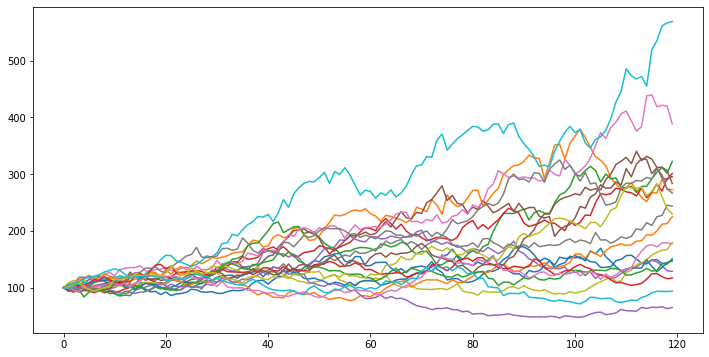

In [4]:
erk.gbm(n_years=10, n_scenarios=20).plot(legend=False, figsize=(12, 6))



## GBM Interactive Plots

In [14]:
def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion model
    """
    s_0=100
    prices = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, s_0=s_0)
    ax = prices.plot(legend=False, color="indianred", alpha = 0.5, linewidth=2, figsize=(12,5))
    ax.axhline(y=100, ls=":", color="black")
    ax.set_ylim(top=400)
    # draw a dot at the origin
    ax.plot(0,s_0, marker='o',color='darkred', alpha=0.2)

In [18]:
gbm_controls = widgets.interactive(show_gbm,
                                   n_scenarios = (1, 20, 5),
                                   mu = (-0.2, 0.2, 0.01),
                                   sigma = (0, 0.3, 0.01)
                                   )

display(gbm_controls)

interactive(children=(IntSlider(value=6, description='n_scenarios', max=20, min=1, step=5), FloatSlider(value=…

## Interactive CPPI Simulation - Montecarlo

In [29]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_ccpi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    y_max=wealth.values.max()*y_max/100
    ax = wealth.plot(legend=False, alpha=0.3, color="indianred", figsize=(12, 6))
    ax.axhline(y=start, ls=":", color="black")
    ax.axhline(y=start*floor, ls="--", color="red")
    ax.set_ylim(top=y_max)




cppi_controls = widgets.interactive(show_cppi,
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50),
                                   mu=(0., +.2, .01),
                                   sigma=(0, .30, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

In [34]:
# Let us plot the histogram of the floor violations

import matplotlib.pyplot as plt
import numpy as np

def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, steps_per_year=12, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=steps_per_year)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_ccpi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]

    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]

    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, start*floor)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios

    e_shortfall = np.dot(terminal_wealth-start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0

    # Plot!
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2,
                                             sharey=True,
                                             gridspec_kw={'width_ratios':[3,2]},
                                             figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)

    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)

    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .9),xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .85),xycoords='axes fraction', fontsize=24)
    if (floor>0.01):
        hist_ax.axhline(y=start*floor, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}",
                         xy=(.7, .7), xycoords='axes fraction', fontsize=24)

cppi_controls = widgets.interactive(show_cppi,
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50),
                                   mu=(0., +.2, .01),
                                   sigma=(0, .3, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   steps_per_year=widgets.IntSlider(min=1, max=12, step=1, value=12,
                                                          description="Rebals/Year"),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…